In [0]:
import numpy as np
from scipy import special
import matplotlib.pyplot as plt
import tensorflow as tf
import skimage, skimage.transform, skimage.data
import skimage.feature, skimage.restoration

In [0]:
def getGaussian2D(npix, 
                  stdev=None,
                  fwhm=None):
    """Generates a circularly symmetric 2d gaussian pattern. 
    
    Ignoring the scaling constants, a circularly symmetric 2d gaussian can be calculated as:
    g = exp(-((x - cx)^2 + (y - cy)^2) / (2 * stdev^2))
    where x and y are the coordinate indices, cx and cy are the coordinates for the center
    of the gaussian, and stdev is the standard deviation. In this function, we assume that 
    cx = cy = npix // 2 (i.e. the center of the gaussian is the center of the 2d array).
    
    Parameters:
    npix - 
    Number of pixels in each axis of the probe
    
    stdev - 
    Standard deviation of the gaussian. The function requires either the standard deviation or the fwhm. 
    
    fwhm - 
    Full width at half maximum (FWHM) of the peak. The function requires either the standard deviation
    or the fwhm. If we supply the fwhm, the standard deviation is calculated as
    stdev = fwhm / 2.35682.
    
    Returns: 
    A 2d array of shape npix X npix and dtype float32.
    """
    
    
    if ((stdev is None) and (fwhm is None)) or ((stdev is not None) and (fwhm is not None)):
        raise KeyError("Should input only one of either stdev or fwhm.")
    if fwhm:
        stdev = fwhm / 2.35682
    
    center = npix // 2
    xvals = np.arange(npix)
    XX, YY = np.meshgrid(xvals, xvals)
    r_squared = (XX - center)**2 + (YY - center)**2
    
    # Ignoring the normalization constants
    gaussian = np.exp(-r_squared/ (2 * stdev**2)) 
    return gaussian.astype('float32')



def getSpeckle(npix, window_size):
    """Generates a speckle pattern. 
    
    To generate a speckle pattern, this function uses a window_size x window_size
    array of complex numbers with unit amplitude and uniformly random phase.
    This array is padded with zeros to get an npix x npix array, an FFT of which
    gives us a speckle pattern. The speckle pattern thus generated is discontinuous;
    there is a phase step of pi between adjacent pixels in both the x and y directions.
    We remove these discontinuities to get the final, continuous, speckle pattern.
    
    Parameters:
    
    npix - 
    Number of pixels along each side of the 2d array containing the speckle pattern.
    
    window_size - 
    The size of the rectangular window used to generate the speckle pattern. 
    Larger window sizes give smaller speckle sizes and vice versa. 
    (Note: I tried a circular window as well, but the results did not change 
    noticeably.)
    
    Returns:
    A 2d array of size npix x npix and dtype complex64.
    """
    
    if window_size > npix: 
        raise ValueError("Window size should be smaller than the size of output array.")
    
    # generating the random array
    ran = np.exp(1j * np.random.rand(npix,npix) * 2 * np.pi)
    
    window = np.zeros((npix, npix))
    indx1 = npix // 2 - window_size // 2
    indx2 = npix // 2 + window_size // 2
    window[indx1: indx2, indx1: indx2] = 1
    
    # Circular window - doesn't change the results.
    #xx, yy = np.meshgrid(np.arange(npix), np.arange(npix))
    #mask = ((xx - npix // 2)**2 + (yy - npix // 2)**2 < (window_size // 2)**2)
    #window[mask] = 1
    
    t = window * ran
    
    ft = np.fft.fftshift(np.fft.fft2(t, norm='ortho'))
    absvals = np.abs(ft)
    angvals = np.angle(ft)
    
    # Removing the discontinuities in the phases 
    angvals[::2] = (angvals[::2] + np.pi) % (2 * np.pi)
    angvals[:,::2] = (angvals[:, ::2] + np.pi) % (2 * np.pi)
    return (absvals * np.exp(1j * angvals)).astype('complex64')



def getSampleObj(npix=256, 
                 mod_range=1,
                 phase_range=np.pi):
    """Creates a sample object using stock data from the skimage module.
    
    Parameters:
    npix - 
    Number of pixels in each axis of the object
    
    mod_range - 
    Maximum value of the modulus for the object pixels.
    
    phase_range - 
    Maximum value of the phase for the object pixels.
    """
    mod_img = skimage.img_as_float(skimage.data.camera())[::-1,::-1]
    phase_img = skimage.img_as_float(skimage.data.immunohistochemistry()[:,:,0])[::-1,::-1]
    mod = skimage.transform.resize(mod_img, [npix, npix], 
                                   mode='wrap', preserve_range=True) * mod_range
    phase = skimage.transform.resize(phase_img, [npix,npix],
                                     mode='wrap', preserve_range=True) * phase_range
    return mod * np.exp(1j * phase)
  
def batch_fftshift2d(tensor: tf.Tensor):
    # Shifts high frequency elements into the center of the filter
    indexes = len(tensor.get_shape()) - 1
    top, bottom = tf.split(tensor, 2, axis=indexes)
    tensor = tf.concat([bottom, top], indexes )
    left, right = tf.split(tensor, 2, axis=indexes - 1)
    tensor = tf.concat([right, left], indexes - 1 )
    return tensor
  
def genViewIndices(probe, obj_w_border, positions):
    npix = probe.shape[0]
    views_indices_all = []
    npix_obj = obj_w_border.shape[0]
    for py, px in positions:
        R, C = np.ogrid[py:npix + py, px:npix + px]
        view_single = (R % npix_obj) * npix_obj + (C % npix_obj)
        views_indices_all.append(view_single)
    return np.array(views_indices_all)

In [0]:
%load_ext autoreload
%autoreload 2

In [0]:
# Generating the object and the probe. 
# For convenience, I am not setting the detector pixel pitch - just working directly with the object plane 
obj_npix = 128
probe_npix = 64
n_photons = 1e6

gaussian_beam_stdev_pixels = 7
gaussian_intensity = getGaussian2D(probe_npix, stdev=gaussian_beam_stdev_pixels)
gaussian_ampl = gaussian_intensity**0.5

speckle = getSpeckle(probe_npix, 10)

probe_true = gaussian_ampl * speckle
probe_true = probe_true * np.sqrt(n_photons / np.sum(np.abs(probe_true)**2))
obj_true = getSampleObj(npix=obj_npix)

In [0]:
# Add free space as border to the object so that the entirety of the object is scanned by the probe
# Since the probe is 64 pixels wide, a border of 32 pixels would be sufficient for this
# I am adding some extra border to account for position changes once I introduce 
# position errors.
obj_w_border = np.pad(obj_true, [[48,48], [48, 48]], mode='constant', constant_values=1.0)
obj_border_npix = obj_w_border.shape[0]

In [0]:
# Calculates the position so that the probe view always fits inside the object dimensions.
num_scan_steps_x = 10
px = np.floor(np.linspace(48, 128 + 48, num_scan_steps_x)).astype('int')

In [11]:
# Cartesian grid of positions for probe centers
grid_position_centers= np.array([(p1, p2) for p1 in px for p2 in px])
grid_position_centers[0] - grid_position_centers[1]

array([  0, -14])

In [0]:
# Assuming that the sample alignment is off by 5 degrees
theta = 5 * np.pi/180
c, s = np.cos(theta), np.sin(theta)
rotation_matrix = np.array(((c,-s), (s, c)))

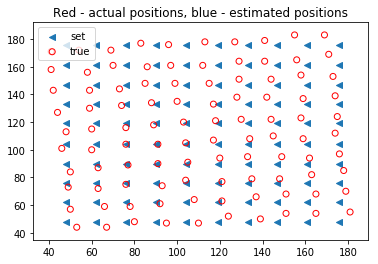

In [21]:
# Introducing rotation + random errors in probe positions
pos_new = (np.reshape(rotation_matrix @ ((grid_position_centers - 64 - 32)[:,:,None]), [-1,2]) 
           + np.random.randint(-2, 2, grid_position_centers.size).reshape([-1,2])) + 64 + 32
grid_position_centers_correct = np.clip(np.ceil(pos_new).astype('int'), 
                                 a_min=16, 
                                 a_max= obj_border_npix - 32)

grid_positions = grid_position_centers - 32
grid_positions_correct = grid_position_centers_correct - 32


plt.scatter(*grid_position_centers.T, marker='<', label='set')
plt.scatter(*grid_position_centers_correct.T, facecolor='none', edgecolor='red', label='true')
plt.legend(loc='upper left')
plt.title('Red - actual positions, blue - estimated positions')
plt.show()

In [0]:
# Generating diffraction patterns for the given number of scan points (in a square grid)
diff_intensities = []

for y, x in grid_positions_correct:
    exit_wave = obj_w_border[y: y + probe_npix, x: x + probe_npix] * probe_true
    exit_wave_ft = np.fft.fftshift(np.fft.fft2(exit_wave, norm='ortho'))
    diff_temp = np.abs(exit_wave_ft)**2
    diff_intensities.append(diff_temp)
        
diff_intensities = np.array(diff_intensities).astype('float32')
# Adding poisson noise
diff_intensities = np.random.poisson(diff_intensities)

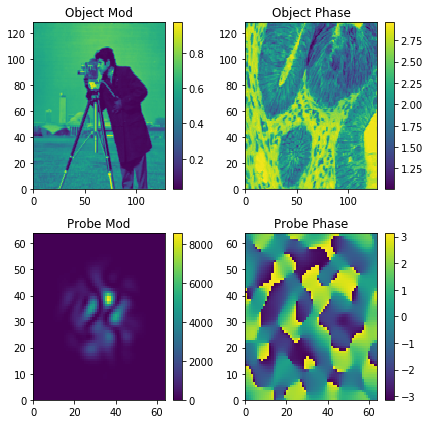

In [23]:
plt.figure(figsize=[6,6])
plot_items = [np.abs(obj_true), np.angle(obj_true), np.abs(probe_true)**2, np.angle(probe_true)]
plot_titles = ['Object Mod', 'Object Phase', 'Probe Mod', 'Probe Phase']
for indx, item in enumerate(plot_items):
    plt.subplot(2, 2, indx + 1)
    plt.pcolormesh(item)
    plt.colorbar()
    plt.title(plot_titles[indx])
plt.tight_layout()
plt.show()

In [0]:
# Initialize the probe with a backpropagation
# Random initalization for the object

probe_init = np.fft.fftshift(np.fft.ifft2(np.mean(np.sqrt(diff_intensities), 
                                                  axis=0), norm='ortho'))

# Not reconstructing the entire object view. 
# Assuming that we have a known support that is slightly (16 pixels) wider
# than the object on each side.
# The reconstructed area is then (128 + 16*2) pixels on each side
recons_obj_npix = obj_border_npix - 32 * 2
obj_init = (np.random.random(recons_obj_npix**2) 
            * np.exp(1j * np.pi * np.random.random(recons_obj_npix**2)))
obj_init = obj_init.reshape(recons_obj_npix, -1)

## Remove discontinuties in probe phase
angs = np.angle(probe_init)
angs[::2] += np.pi
angs[:,::2] += np.pi
probe_init = np.abs(probe_init) * np.exp(1j * angs)

In [26]:
recons_obj_npix, obj_true.shape

(160, (128, 128))

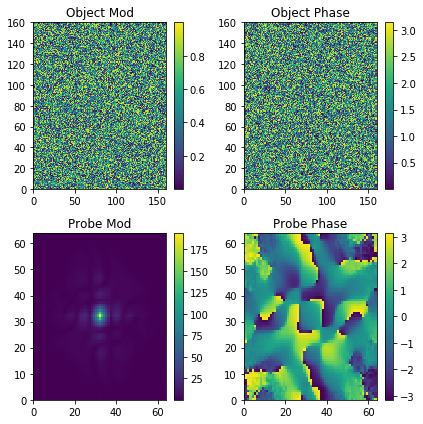

In [27]:
plt.figure(figsize=[6,6])
plot_items = [np.abs(obj_init), np.angle(obj_init), np.abs(probe_init), np.angle(probe_init)]
plot_titles = ['Object Mod', 'Object Phase', 'Probe Mod', 'Probe Phase']
for indx, item in enumerate(plot_items):
    plt.subplot(2, 2, indx + 1)
    plt.pcolormesh(item)
    plt.colorbar()
    plt.title(plot_titles[indx])
plt.tight_layout()
plt.show()

In [0]:
# Creating the variables for the reconstruction

tf.reset_default_graph()
tf_obj_reals = tf.Variable(np.array([np.real(obj_init),
                            np.imag(obj_init)]),
                           dtype='float32')
tf_probe_reals = tf.Variable(np.array([np.real(probe_init),
                              np.imag(probe_init)]),
                             dtype='float32')

tf_obj = tf.complex(tf_obj_reals[0], tf_obj_reals[1])
tf_probe = tf.complex(tf_probe_reals[0], tf_probe_reals[1])

ndiffs, npix, _ = diff_intensities.shape
shifted_intensities = np.fft.fftshift(diff_intensities, axes=(1,2))
tf_mods = tf.sqrt(tf.constant(shifted_intensities, dtype='float32'))

# Variable that holds the position shifts. We solve for this in addition to probe and object
tf_position_shifts = tf.Variable(np.zeros(grid_positions.shape), 
                                 dtype='float32')

In [0]:
# Fixing the object inside the support.
# Surrounding the object by a known free space border (magnitude 1)
# also removes the affine phase ambiguity.
# See works by A. Fannjiang.
tf_obj_w_border = tf.pad(tf_obj, [[32,32],[32,32]],
                         mode='constant', constant_values=1.0)

In [0]:
# Creating a "clip" operation that projects the object guess to magnitude [0.0, 1.0]
tf_obj_mag = tf.abs(tf_obj)
mult_factor =   tf.clip_by_value(tf_obj_mag, 0, 1.0) / (tf_obj_mag + 1e-10)
tf_obj_clipped = tf_obj * tf.cast(mult_factor, tf.complex64)
obj_clip_op = [tf.assign(tf_obj_reals, tf.stack([tf.real(tf_obj_clipped),
                                                 tf.imag(tf_obj_clipped)]))]

In [0]:
# Generating object "views"
obj_view_indices = genViewIndices(probe_true, obj_w_border, grid_positions)
tf_obj_view_indices = tf.constant(obj_view_indices)

In [33]:
# Introducing minibatches
batch_size = 50

dataset_indices = tf.data.Dataset.range(ndiffs)
dataset_indices = dataset_indices.shuffle(ndiffs)
dataset_indices = dataset_indices.repeat()
dataset_batch = dataset_indices.batch(batch_size, drop_remainder=True)
dataset_batch = dataset_batch.apply(tf.data.experimental.prefetch_to_device('/gpu:0', buffer_size=5))
            
iterator = dataset_batch.make_one_shot_iterator()

batchi_t = iterator.get_next()
batch_indices_v = tf.Variable(tf.zeros(batch_size, dtype=tf.int64),
                              name='batch_indices', trainable=False)
new_batch_op = batch_indices_v.assign(batchi_t)
            
batch_mods = tf.gather(tf_mods, batch_indices_v)
batch_obj_view_indices = tf.gather(tf_obj_view_indices, batch_indices_v)

W0813 20:42:41.389584 140679918765952 deprecation.py:323] From <ipython-input-33-f6b809dad242>:9: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


In [0]:
batch_obj_views = tf.gather(tf.reshape(tf_obj_w_border, [-1]), 
                                      batch_obj_view_indices)

In [0]:
# Defining the amplitude-based loss, using the entire data set at once.
# Creating batches is somewhat complicated, and beyond the scope of this notebook.
# This implmentation is simple conceptually but not the most efficient.
#tf_obj_views_all = []
#for i, (y, x) in enumerate(grid_positions):
#    this_obj_view = tf_obj_w_border[y: y + npix, x: x + npix]
#    tf_obj_views_all.append(this_obj_view)

#tf_obj_views_all = tf.stack(tf_obj_views_all)

In [0]:
batch_position_shifts = tf.gather(tf_position_shifts, batch_indices_v)

In [0]:
# position correction as a phase ramp in fourier space
# Defining the amplitude-based loss
# --------------------------------------------------------------------------------------------


tU = tf.range(npix, dtype='float32')
tfactor = (-2 * np.pi * (tU * batch_position_shifts[:,1,None,None] 
                        + tU[:,None] * batch_position_shifts[:,0,None,None]) 
           / npix)
phase_ramp = tf.complex(tf.cos(tfactor), tf.sin(tfactor))

tf_exit_waves = batch_obj_views * tf.ifft2d(tf.fft2d(tf_probe) * 
                                            batch_fftshift2d(phase_ramp)) 
# ----------------------------------------------------------------------------------------------
tf_fts = tf.fft2d(tf_exit_waves) / npix
loss = 0.5 * tf.reduce_sum((tf.abs(tf_fts) - batch_mods)**2)

In [37]:
# For simplicity, I am using the Adam optimizer. 
# Using the lipschitz constants for the learning rates in a gradient descent process is quite complicated. 

# The learning rates were obtained through trial and error.

obj_optimizer = tf.train.AdamOptimizer(1e-2)
probe_optimizer = tf.train.AdamOptimizer(1e-1)

probe_min = probe_optimizer.minimize(loss, var_list=[tf_probe_reals])
obj_min = obj_optimizer.minimize(loss, var_list=[tf_obj_reals])

# Solving for the position drifts
position_opt = tf.train.AdamOptimizer(learning_rate=1e-3)
position_min = position_opt.minimize(loss, var_list=[tf_position_shifts])

W0813 20:45:13.552456 140679918765952 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
session = tf.Session()
session.run(tf.global_variables_initializer())
_ = session.run(new_batch_op)

In [0]:
lossvals_array = []

In [40]:
# initial average error in position
pos_error_before_recons = np.abs(grid_positions_correct - grid_positions).sum(axis=0) / grid_positions.size
pos_error_before_recons

array([1.63 , 1.695])

In [41]:
# Actual minimization procedure. 
# Minimizing both the probe and the object simultaneously.
for i in range(30000):
    # new_batch_op changes the current minbatch
    session.run(new_batch_op)
    session.run([obj_min, position_min, probe_min])
    
    # using the object projection every 100 steps
    if i % 100 == 0: session.run(obj_clip_op)
    # calculating the current reconstruction error
    if i % 1000== 0:
        lossval, recons_pos, recons_obj = session.run([loss, 
                                                       tf_position_shifts,
                                                       tf_obj])
        grid_positions_new = recons_pos + grid_positions
        pos_error_after_recons = (np.abs(grid_positions_correct - 
                                        grid_positions_new).sum(axis=0) 
                                  / grid_positions.size)
        
        recons_obj = session.run(tf_obj)
        var_true = np.pad(obj_true, [16, 16], 
                          mode='constant',
                          constant_values=1.0)
        roll, err, phase = skimage.feature.register_translation(var_true, 
                                                            recons_obj,
                                                            upsample_factor=5)
        
        print(f'Iterations = {i:5.3g}   Loss = {lossval:5.3g}  ' 
              + f'Pos error after recon {pos_error_after_recons}  '
              + f'Recons error {roll} {err:5.3g} {phase:5.3g}')
    
        lossvals_array.append(lossval)
    
        if lossval < 1e-5:
            break

recons_obj = session.run(tf_obj)
recons_probe = session.run(tf_probe)
print('Current loss is', lossvals_array[-1])

Iterations =     0   Loss = 6.55e+06  Pos error after recon [1.63005 1.69496]  Recons error [22.8 69.2]  0.97 -0.742
Iterations = 1e+03   Loss = 6.55e+05  Pos error after recon [1.6365328  1.68936404]  Recons error [1.6 6.4] 0.847 -0.339
Iterations = 2e+03   Loss = 4.77e+05  Pos error after recon [1.63209613 1.68588495]  Recons error [1.2 6.8] 0.746  -0.5
Iterations = 3e+03   Loss = 2.12e+05  Pos error after recon [1.59083614 1.63202626]  Recons error [-0.8  9. ] 0.588 -0.392
Iterations = 4e+03   Loss = 1.14e+05  Pos error after recon [1.44879106 1.50647429]  Recons error [-2.   9.8]   0.5 -0.22
Iterations = 5e+03   Loss = 1.01e+05  Pos error after recon [1.3101723  1.36645117]  Recons error [-1.6  8. ] 0.451 -0.101
Iterations = 6e+03   Loss = 8.78e+04  Pos error after recon [1.15571561 1.21529449]  Recons error [-1.6  8. ] 0.423 -0.0337
Iterations = 7e+03   Loss = 8.53e+04  Pos error after recon [1.01214025 1.06804497]  Recons error [-2.  8.] 0.398 0.000269
Iterations = 8e+03   Loss =

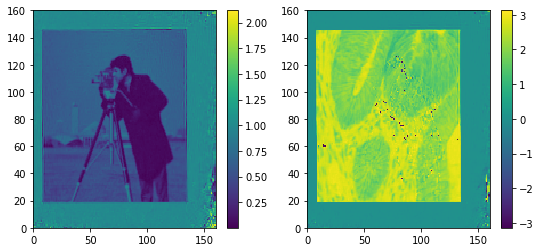

In [44]:
# REconstructed object
rcons_obj = session.run(tf_obj)
plt.figure(figsize=[9,4])
plt.subplot(1,2,1)
plt.pcolormesh(np.abs(rcons_obj))
plt.colorbar()
plt.subplot(1,2,2)
plt.pcolormesh(np.angle(rcons_obj))
plt.colorbar()
plt.show()

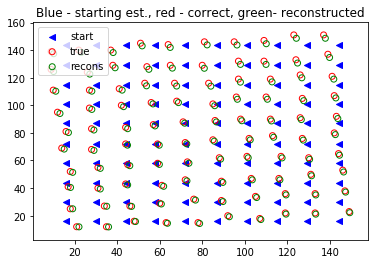

In [45]:
# Reconstructed scan position
plt.scatter(*grid_positions.T, marker='<', facecolors='blue', edgecolors='blue', label='start')
plt.scatter(*grid_positions_correct.T, marker='o', facecolors='none', edgecolors='red', label='true')
plt.scatter(*grid_positions_new.T, marker='o', facecolors='none', edgecolors='green', label='recons')
plt.legend(loc='upper left')
plt.title('Blue - starting est., red - correct, green- reconstructed')
plt.show()